Original Class Distribution: Counter({1: 1655, 2: 295, 3: 176})
After SMOTE Class Distribution: Counter({2: 1655, 1: 1655, 3: 1655})

KNN - Accuracy: 93.66%
              precision    recall  f1-score   support

           1       0.98      0.86      0.92       353
           2       0.86      0.97      0.91       317
           3       0.98      0.99      0.98       323

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993



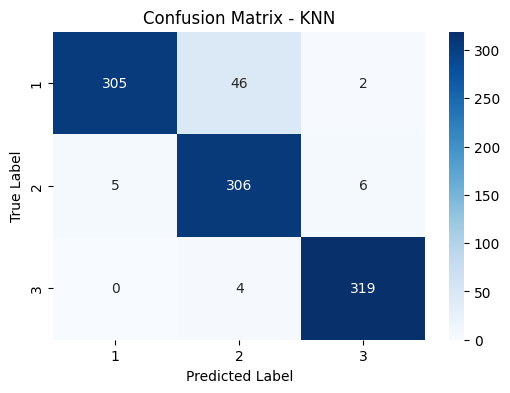


XGBoost - Accuracy: 93.55%
              precision    recall  f1-score   support

           1       0.98      0.88      0.93       353
           2       0.85      0.97      0.91       317
           3       0.99      0.96      0.98       323

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993



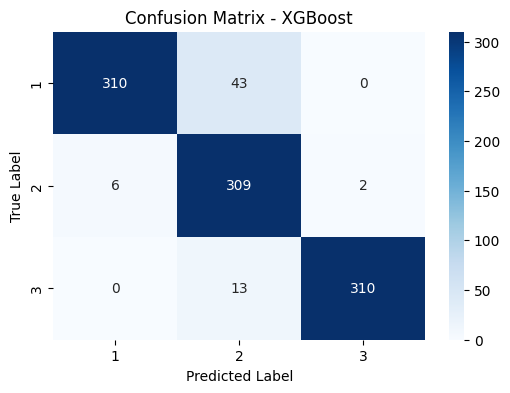


Random Forest - Accuracy: 95.77%
              precision    recall  f1-score   support

           1       0.99      0.92      0.95       353
           2       0.89      0.99      0.94       317
           3       1.00      0.96      0.98       323

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.96      0.96      0.96       993



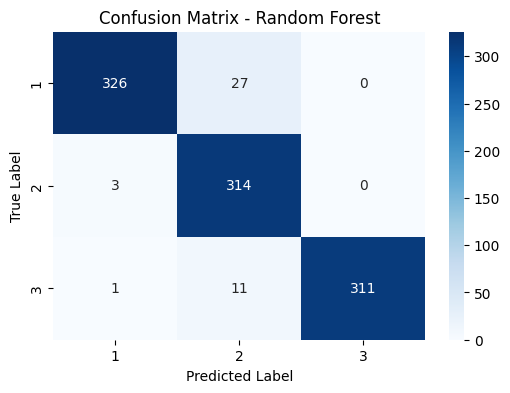


Gradient Boosting - Accuracy: 93.66%
              precision    recall  f1-score   support

           1       0.98      0.88      0.93       353
           2       0.85      0.97      0.91       317
           3       0.99      0.96      0.98       323

    accuracy                           0.94       993
   macro avg       0.94      0.94      0.94       993
weighted avg       0.94      0.94      0.94       993



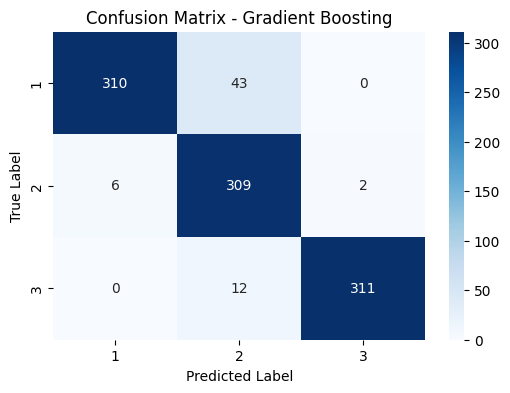


Ensemble Model - Accuracy: 96.27%
              precision    recall  f1-score   support

           1       0.99      0.92      0.96       353
           2       0.90      0.99      0.94       317
           3       1.00      0.98      0.99       323

    accuracy                           0.96       993
   macro avg       0.96      0.96      0.96       993
weighted avg       0.97      0.96      0.96       993



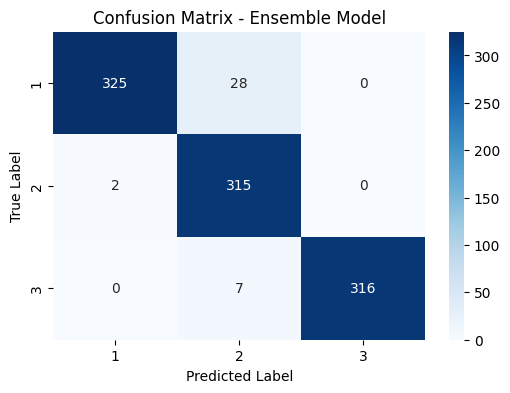

Predicted Class Number: 2
Predicted Class Name: Suspect


PermutationExplainer explainer:   0%|          | 3/993 [01:35<13:06:57, 47.69s/it]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load dataset
df = pd.read_csv("fetal_health.csv")

# Define features and target
X = df.iloc[:, :-1].to_numpy()  # Features
y = df.iloc[:, -1].to_numpy().astype(int)  # Ensure integer class labels

# Display original class distribution
print("Original Class Distribution:", Counter(y))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert y_resampled to integer type (SMOTE might introduce float labels)
y_resampled = y_resampled.astype(int)

# Display new class distribution
print("After SMOTE Class Distribution:", Counter(y_resampled))

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------------------
# ✅ 1. Manual K-Nearest Neighbors (KNN)
# --------------------------------------
class ManualKNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x in X:
            distances = np.linalg.norm(self.X_train - x, axis=1)  # Efficient vectorized distance calculation
            k_neighbors = np.argsort(distances)[:self.k]
            labels = [self.y_train[i] for i in k_neighbors]
            predictions.append(Counter(labels).most_common(1)[0][0])
        return np.array(predictions)

# --------------------------------------
# ✅ 2. Manual XGBoost
# --------------------------------------
class XGBoostManual:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators  # Number of boosting rounds (trees)
        self.learning_rate = learning_rate  # Learning rate (eta)
        self.max_depth = max_depth  # Tree depth
        self.trees = []  # Store trees
        self.base_pred = None  # Base prediction

    def fit(self, X_train, y_train):
        # Initialize with mean prediction (base score)
        self.base_pred = np.mean(y_train)
        y_pred = np.full(y_train.shape, self.base_pred)

        # Train trees sequentially
        for _ in range(self.n_estimators):
            # Compute residuals (gradients) as negative gradients of loss function
            residuals = y_train - y_pred

            # Train a weak learner (Decision Tree) to fit the residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X_train, residuals)

            # Predict residuals with the new tree
            residual_pred = tree.predict(X_train)

            # Update prediction with learning rate * residual correction
            y_pred += self.learning_rate * residual_pred

            # Store the trained tree
            self.trees.append(tree)

    def predict(self, X_test):
        # Start with base prediction
        y_pred = np.full((X_test.shape[0],), self.base_pred)

        # Aggregate predictions from all trees
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X_test)

        # Round predictions to nearest class
        return np.round(y_pred).astype(int)

# --------------------------------------
# ✅ 3. Manual Random Forest
# --------------------------------------
class ManualRandomForest:
    def __init__(self, n_trees=50, max_depth=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        for _ in range(self.n_trees):
            indices = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X[indices], y[indices])
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.round(np.mean(predictions, axis=0)).astype(int)

# --------------------------------------
# ✅ 4. Manual Gradient Boosting
# --------------------------------------
class ManualGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        self.initial_prediction = None

    def fit(self, X, y):
        self.initial_prediction = np.mean(y)
        y_pred = np.full(y.shape, self.initial_prediction)

        for _ in range(self.n_estimators):
            residuals = y - y_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            y_pred += self.learning_rate * tree.predict(X)
            self.trees.append(tree)

    def predict(self, X):
        y_pred = np.full((X.shape[0],), self.initial_prediction)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(X)
        return np.round(y_pred).astype(int)

# --------------------------------------
# ✅ Train and Evaluate Models
# --------------------------------------
models = {
    "KNN": ManualKNN(k=5),
    "XGBoost": XGBoostManual(n_estimators=100, learning_rate=0.1, max_depth=3),
    "Random Forest": ManualRandomForest(n_trees=50, max_depth=10),
    "Gradient Boosting": ManualGradientBoosting(n_estimators=100, learning_rate=0.1, max_depth=3)
}

predictions = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    print(f"\n{name} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
    print(classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# ✅ Manual Ensembling (Majority Voting)
y_pred_ensemble = np.array([Counter([predictions[model][i] for model in models]).most_common(1)[0][0] for i in range(len(y_test))])

# Evaluate ensemble model
print(f"\nEnsemble Model - Accuracy: {accuracy_score(y_test, y_pred_ensemble) * 100:.2f}%")
print(classification_report(y_test, y_pred_ensemble))

# Plot Confusion Matrix for Ensemble Model
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ensemble Model")
plt.show()

new_data_class_2 = pd.DataFrame({
    'baseline value': [120],  # Higher baseline value, could be indicative of a different class
    'accelerations': [0],  # Acceleration might be higher for class 2
    'fetal_movement': [0],  # Slightly more fetal movement
    'uterine_contractions': [0],  # Uterine contractions might be more frequent for class 2
    'light_decelerations': [0],  # Slightly more decelerations
    'severe_decelerations': [0],  # Mild severe deceleration
    'prolongued_decelerations': [0],  # Prolonged decelerations slightly higher
    'abnormal_short_term_variability': [73],  # Short term variability higher
    'mean_value_of_short_term_variability': [0.5],  # Increased mean value
    'percentage_of_time_with_abnormal_long_term_variability': [43],  # More time with abnormal long-term variability
    'mean_value_of_long_term_variability': [2.4],  # Increased mean value for long-term variability
    'histogram_width': [64],  # Wider histogram could indicate different characteristics
    'histogram_min': [62],
    'histogram_max': [126],  # Higher maximum could indicate a different class
    'histogram_number_of_peaks': [2],  # More peaks in the histogram
    'histogram_number_of_zeroes': [0],  # More zeros might correlate with different patterns
    'histogram_mode': [120],  # Mode might be higher
    'histogram_mean': [137],  # Higher mean value
    'histogram_median': [121],  # Higher median
    'histogram_variance': [73],  # More variance
    'histogram_tendency': [1]  # Slightly more tendency
})
# Class labels mapping
class_labels = {1: 'Normal', 2: 'Suspect', 3: 'Pathological'}

# Scale the new data using the fitted scaler
# Convert DataFrame to NumPy array before scaling
new_data_scaled = scaler.transform(new_data_class_2.to_numpy())

# Predict using individual models
model_predictions = []
for name, model in models.items():
    pred = model.predict(new_data_scaled)
    model_predictions.append(pred[0])

# Majority voting (Ensemble Prediction)
final_prediction = Counter(model_predictions).most_common(1)[0][0]

# Get class name from class_labels dictionary
predicted_class_name = class_labels[final_prediction]

# Print final result
print(f"Predicted Class Number: {final_prediction}")
print(f"Predicted Class Name: {predicted_class_name}")

import shap

# Initialize SHAP explainer and compute SHAP values for each model
shap_values_dict = {}
explainer_dict = {}

for name, model in models.items():
    explainer = shap.Explainer(model.predict, X_train_scaled)
    shap_values = explainer(X_test_scaled)
    shap_values_dict[name] = shap_values
    explainer_dict[name] = explainer

    # Plot SHAP summary plot
    shap.summary_plot(shap_values, X_test_scaled, feature_names=df.columns[:-1])

# SHAP for Ensemble Model
ensemble_explainer = shap.Explainer(lambda X: np.array([Counter([predictions[model][i] for model in models]).most_common(1)[0][0] for i in range(len(X))]), X_train_scaled)
shap_values_ensemble = ensemble_explainer(X_test_scaled)
shap.summary_plot(shap_values_ensemble, X_test_scaled, feature_names=df.columns[:-1])
